# MID-SEMESTER EXAM 2024-2025
# Machine Learning
Neural Network (NN) Classification on Image Data
# Intro

In this mid-term exam, you are asked to classify facial images using the Casia-Webface dataset (Data can be downloaded on Kaggle).
You are allowed to explore:
1. Pre-processing methods
2. Feature selection
3. ANN architecture
4. Activation function
5. Evaluation metrics

Kelompok :
1. Asti Nurin Hidayanti / 2241720236
2. Ellois Karina Handoyo / 2241720154
3. Mohammad Naufal Syahandra / 2241720189
4. Rio Bagas Hermawan / 2241720193

In [ ]:
import kagglehub
import numpy as np
import os
import shutil
import tensorflow as tf

# Ensure the CASIA-Webface dataset has been downloaded to the correct directory
path = kagglehub.dataset_download("ntl0601/casia-webface")

destination_path = "/content/casia-webface/"

# Check if the destination directory exists, if not, create it
if not os.path.exists(destination_path):
    os.makedirs(destination_path)

# Move all files from the download folder to the destination folder
for filename in os.listdir(path):
    shutil.move(os.path.join(path, filename), os.path.join(destination_path, filename))

print("Path to dataset files:", destination_path)


Path to dataset files: /content/casia-webface/


# donlot kaggle

In [ ]:
import os
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from collections import Counter

def load_data(data_dir, target_size=(112, 112), min_images_per_person=200, max_images_per_person=200, max_persons=5000):
    data = []
    label_map = {}  # Map folder names to numeric labels
    images_per_label = Counter()  # Count images per label

    # Get all folders (e.g., 00001, 00002, ...)
    person_folders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))]

    # Process up to a maximum of max_persons folders (persons)
    person_folders = person_folders[:max_persons]

    # Process each folder
    for idx, person in enumerate(person_folders):
        person_path = os.path.join(data_dir, person)
        img_files = [f for f in os.listdir(person_path) if f.endswith('.jpg')]

        # Skip this folder if it has fewer than min_images_per_person images
        if len(img_files) < min_images_per_person:
            continue

        img_count = 0  # Initialize image counter per person

        # Assign a label number based on folder order
        label_map[person] = idx

        # Load images from this folder
        for img_file in img_files[:max_images_per_person]:  # Take up to max_images_per_person images
            img_path = os.path.join(person_path, img_file)

            # Load and resize the image
            img = load_img(img_path, target_size=target_size)
            img_array = img_to_array(img)
            img_array = img_array / 255.0  # Normalize between 0 and 1

            # Append image and label to data
            data.append((img_array, idx))  # idx is the numeric label

            img_count += 1  # Increment image counter
            images_per_label[idx] += 1  # Increment count for this label

            # Stop if max_images_per_person limit is reached
            if img_count >= max_images_per_person:
                break

    # Convert to NumPy arrays (images only)
    images_array = np.array([img for img, _ in data])
    labels_array = np.array([label for _, label in data])

    return images_array, labels_array, images_per_label

# Path to the dataset
data_directory = '/content/casia-webface/casia-webface'

images, labels, images_per_label = load_data(data_directory)

print("Shape of images array:", images.shape)
print("Shape of labels array:", labels.shape)

# Display image count per label
for label, count in images_per_label.items():
    print(f"Label {label}: {count} images")


Shape of images array: (30400, 112, 112, 3)
Shape of labels array: (30400,)
Label 23: 200 images
Label 61: 200 images
Label 75: 200 images
Label 106: 200 images
Label 120: 200 images
Label 174: 200 images
Label 266: 200 images
Label 268: 200 images
Label 306: 200 images
Label 320: 200 images
Label 332: 200 images
Label 377: 200 images
Label 398: 200 images
Label 424: 200 images
Label 445: 200 images
Label 472: 200 images
Label 508: 200 images
Label 572: 200 images
Label 617: 200 images
Label 642: 200 images
Label 698: 200 images
Label 754: 200 images
Label 770: 200 images
Label 852: 200 images
Label 888: 200 images
Label 946: 200 images
Label 951: 200 images
Label 1006: 200 images
Label 1008: 200 images
Label 1038: 200 images
Label 1047: 200 images
Label 1067: 200 images
Label 1112: 200 images
Label 1113: 200 images
Label 1115: 200 images
Label 1170: 200 images
Label 1268: 200 images
Label 1283: 200 images
Label 1287: 200 images
Label 1313: 200 images
Label 1359: 200 images
Label 1366:

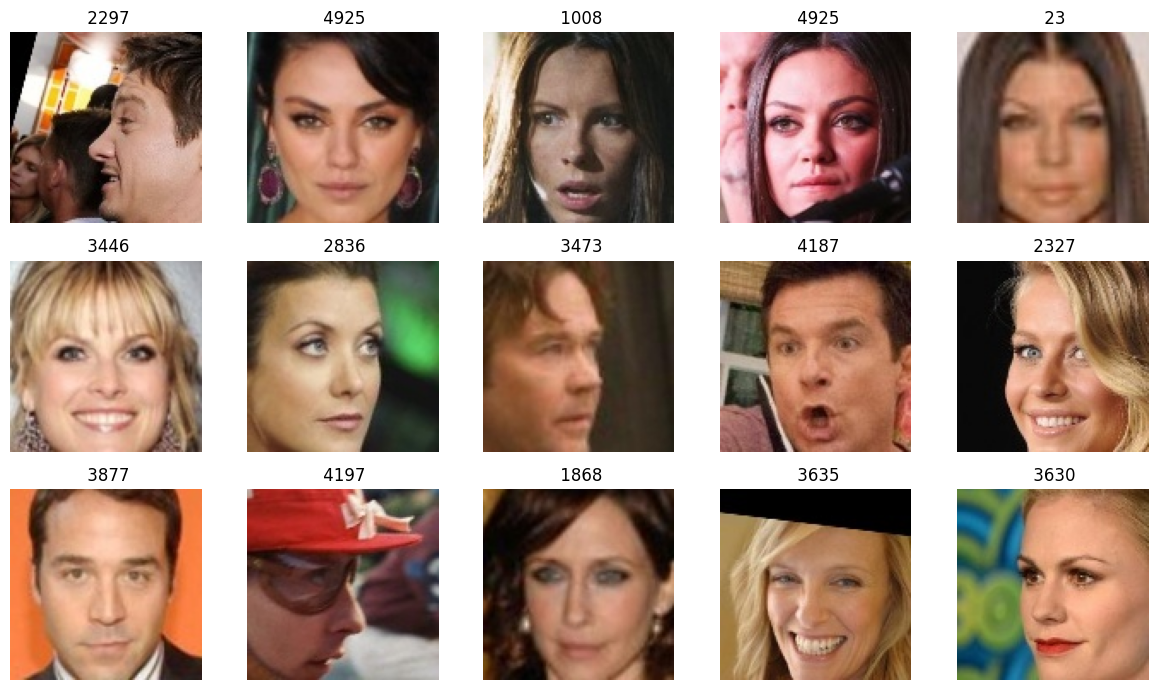

In [ ]:
from random import sample
import matplotlib.pyplot as plt

random_indices = sample(range(images.shape[0]), 15)

plt.figure(figsize=(12, 7))
for i, idx in enumerate(random_indices):
    plt.subplot(3, 5, i + 1)
    plt.imshow(images[idx], cmap='bone')
    plt.title(f' {labels[idx]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# load data

In [ ]:
print("Jumlah Orang: ", len(np.unique(labels)))

Jumlah Orang:  152


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Convert labels to categorical
num_classes = len(label_encoder.classes_)  # Updated to the number of unique classes
labels_categorical = to_categorical(labels_encoded, num_classes=num_classes)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

In [ ]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(112, 112, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

Epoch 1/50
760/760 [==============================] - 64s 83ms/step - loss: 3.5277 - accuracy: 0.1868 - val_loss: 3.3014 - val_accuracy: 0.3105
Epoch 2/50
760/760 [==============================] - 60s 79ms/step - loss: 3.2897 - accuracy: 0.2397 - val_loss: 2.9847 - val_accuracy: 0.3781
Epoch 3/50
760/760 [==============================] - 59s 78ms/step - loss: 3.0719 - accuracy: 0.2725 - val_loss: 2.7242 - val_accuracy: 0.4375
Epoch 4/50
760/760 [==============================] - 60s 79ms/step - loss: 2.8645 - accuracy: 0.3186 - val_loss: 2.5846 - val_accuracy: 0.4743
Epoch 5/50
760/760 [==============================] - 60s 79ms/step - loss: 2.7127 - accuracy: 0.3478 - val_loss: 2.5008 - val_accuracy: 0.4962
Epoch 6/50
760/760 [==============================] - 61s 80ms/step - loss: 2.5800 - accuracy: 0.3765 - val_loss: 2.2598 - val_accuracy: 0.5332
Epoch 7/50
760/760 [==============================] - 58s 77ms/step - loss: 2.4616 - accuracy: 0.4001 - val_loss: 2.1948 - val_accuracy: